# Unzipping .zip dataset

In [1]:
!gdown --id '1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7' --output 'dataset.zip'

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7
From (redirected): https://drive.google.com/uc?id=1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7&confirm=t&uuid=ce508257-b85b-44ac-b27b-a295b70c0b1d
To: /content/dataset.zip
100% 78.1M/78.1M [00:00<00:00, 107MB/s]


In [2]:
!unzip dataset.zip -d dataset

Archive:  dataset.zip
   creating: dataset/Actor_01/
  inflating: dataset/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: dataset/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: dataset/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: dataset/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: dataset/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: dataset/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: dataset/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: dataset/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: dataset/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: dataset/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: dataset/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: dataset/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: dataset/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: dataset/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: dataset/Actor_01/03-01-03-01-02-01-01.wav  
  inflating: dataset/Actor_01/03-01-03-01-02-02-01.wav  
  inflating: dataset/Actor_01/03-01

# Import

In [3]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=088eca429de3cde17dc54b0d98e1096f00cc7adc8bf08b6d9e7773d5e1044fd2
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [22]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import np_utils

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,GRU,Bidirectional
import math

# Read sound files and pre-process

In [23]:
dataset_path = "./dataset/"

dataset_directory_list = os.listdir(dataset_path)

file_emotion = []
file_path = []
for dir in dataset_directory_list:
    actor = os.listdir(dataset_path + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(dataset_path + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
dataset_df = pd.concat([emotion_df, path_df], axis=1)

dataset_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
dataset_df.head()


,Emotions,Path
0,disgust,./dataset/Actor_04/03-01-07-01-02-01-04.wav
1,angry,./dataset/Actor_04/03-01-05-02-02-02-04.wav
2,sad,./dataset/Actor_04/03-01-04-02-02-02-04.wav
3,fear,./dataset/Actor_04/03-01-06-01-02-02-04.wav
4,disgust,./dataset/Actor_04/03-01-07-02-02-02-04.wav


In [24]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  1440 non-null   object
 1   Path      1440 non-null   object
dtypes: object(2)
memory usage: 22.6+ KB


In [25]:
dataset_df.describe()

,Emotions,Path
count,1440,1440
unique,8,1440
top,disgust,./dataset/Actor_04/03-01-07-01-02-01-04.wav
freq,192,1


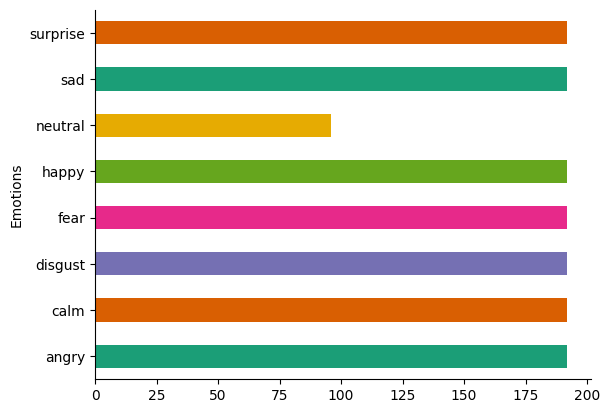

In [26]:
# Emotion Count Graph
dataset_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [27]:
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

Sampling Rate: 22050


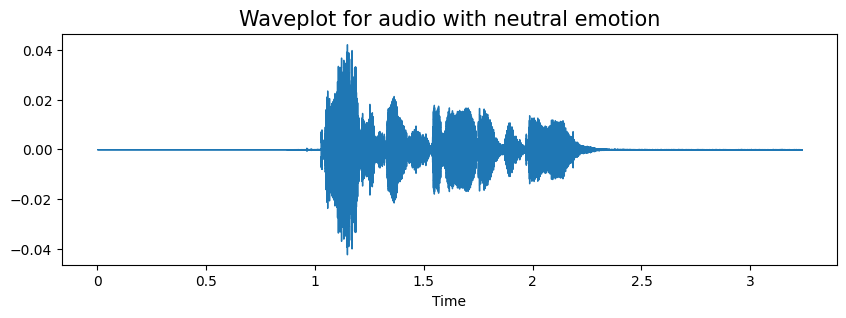

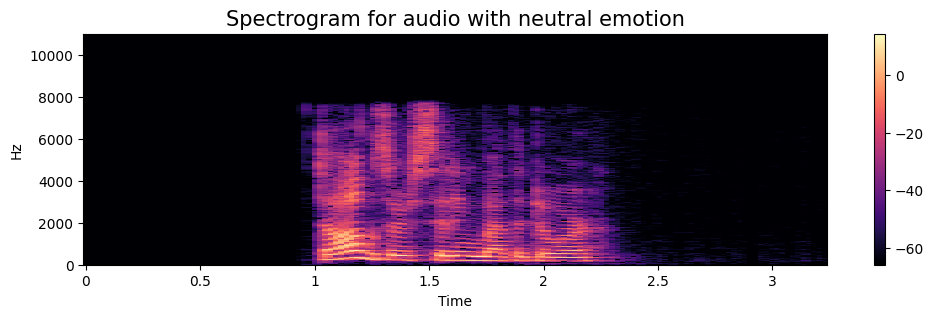

In [28]:
#  wavplot and spectogram a NORMAL sample

import matplotlib.pyplot as plt

emotion='neutral'
path = np.array(dataset_df.Path[dataset_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)

print(f"Sampling Rate: {sampling_rate}")

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)



Sampling Rate: 22050


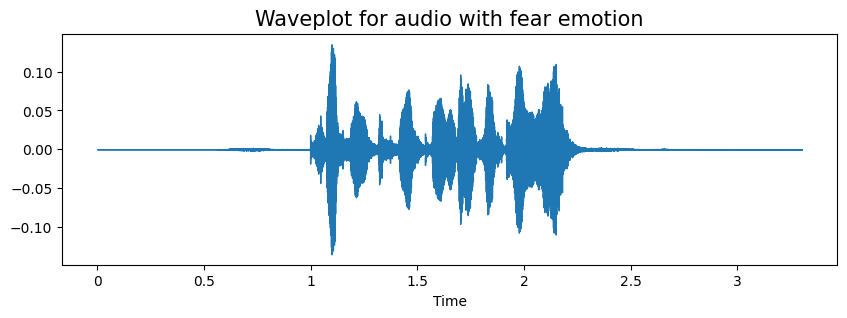

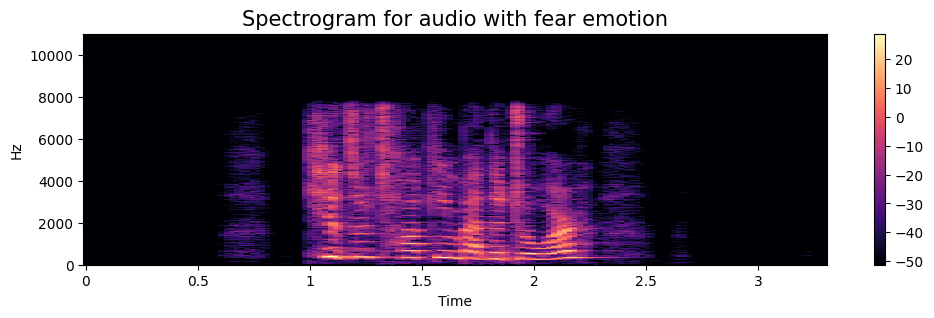

In [29]:
# wavplot and spectogram a FEAR sample

import matplotlib.pyplot as plt

emotion='fear'
path = np.array(dataset_df.Path[dataset_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)

print(f"Sampling Rate: {sampling_rate}")

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)



Sampling Rate: 22050


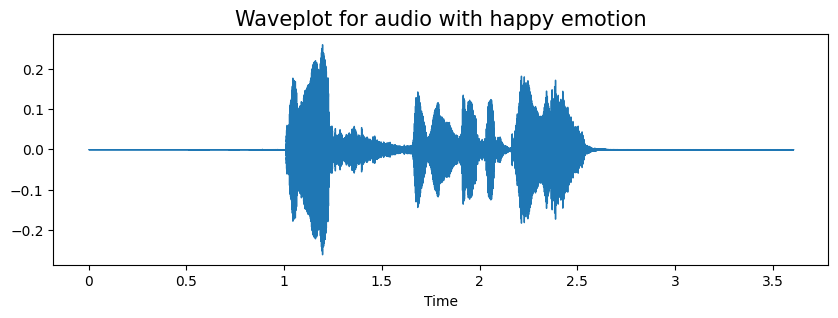

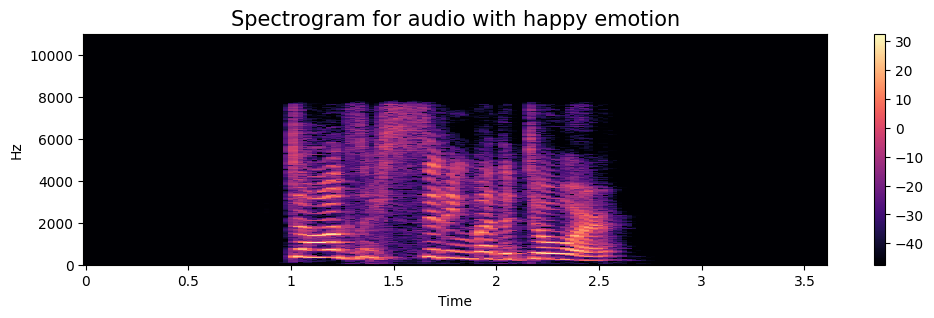

In [30]:
# wavplot and spectogram a HAPPY sample

import matplotlib.pyplot as plt

emotion='happy'
path = np.array(dataset_df.Path[dataset_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)

print(f"Sampling Rate: {sampling_rate}")

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)



./dataset/Actor_04/03-01-05-02-01-01-04.wav
Sampling Rate: 22050


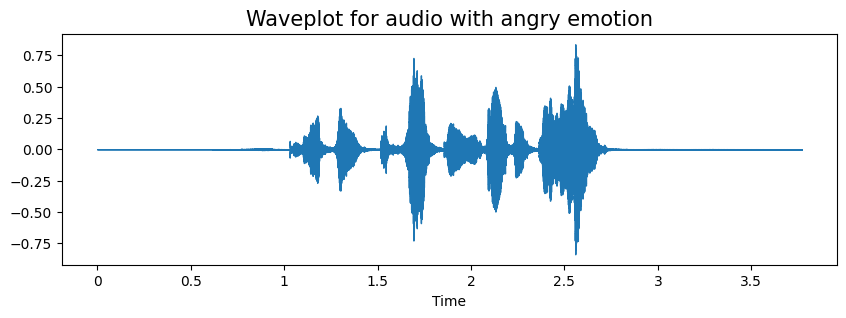

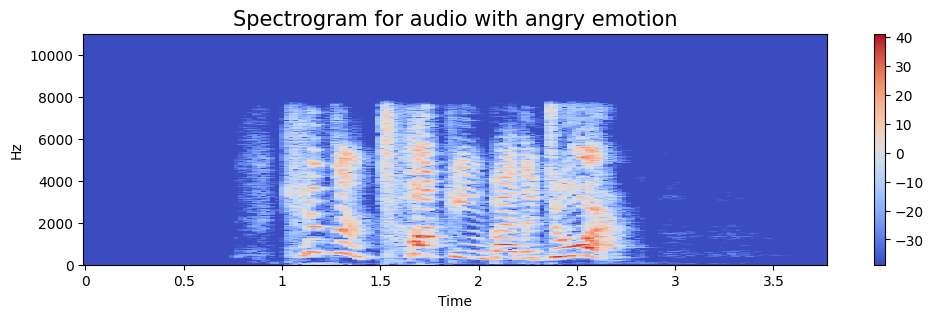

In [31]:
# wavplot and spectogram a ANGRY sample

import matplotlib.pyplot as plt

emotion='angry'
path = np.array(dataset_df.Path[dataset_df.Emotions==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)

print(f"Sampling Rate: {sampling_rate}")

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)



In [32]:
!pip install soundfile

In [33]:
!pip install noisereduce

In [34]:
Audio("./voice-with-background-noise.wav")

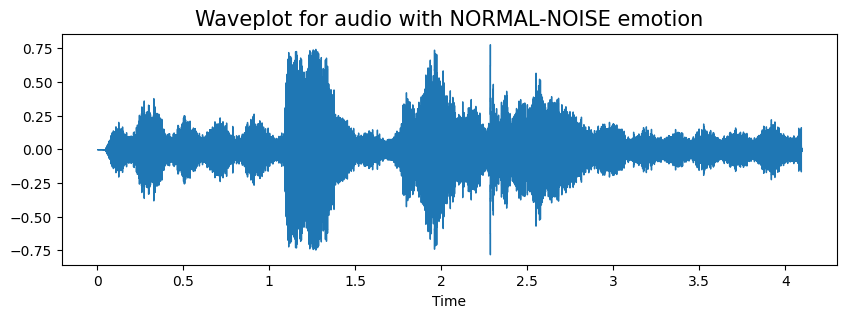

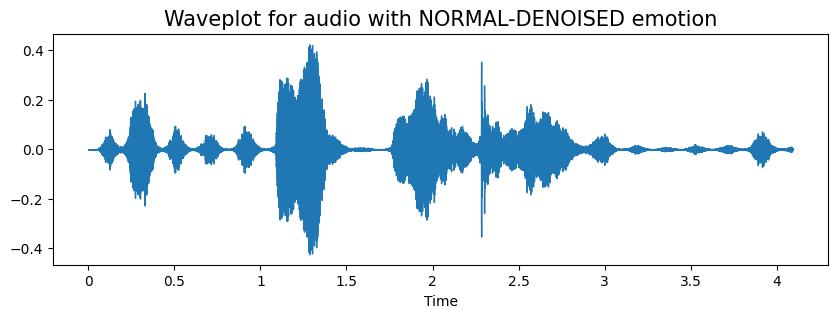

In [35]:
import soundfile as sf
import noisereduce as nr

data, sr = librosa.load("./voice-with-background-noise.wav")

create_waveplot(data, sr, "NORMAL-NOISE")

data_denoised = nr.reduce_noise(data, sr)

# Save the denoised audio
sf.write('./denoised_audio.wav', data_denoised * 10, sr)

create_waveplot(data_denoised, sr, "NORMAL-DENOISED")

Audio("./denoised_audio.wav")

In [36]:
# data augmentation functions

def denoise(data, sr):
    data = nr.reduce_noise(data, sr)
    return data

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(dataset_df.Path)[1]
data, sample_rate = librosa.load(path)

In [37]:
# feature extraction fuctions

def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [38]:
X, Y = [], []
for path, emotion in zip(dataset_df.Path, dataset_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [39]:
# saving features into csv file
!mkdir dataset_clean
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('./dataset_clean/features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.184204,0.454253,0.485038,0.476325,0.445979,0.455501,0.470174,0.467917,0.477137,0.574886,...,1.146382e-14,9.602835e-15,8.612696e-15,7.540092e-15,6.680197e-15,6.046355e-15,6.644248e-15,7.807805e-15,6.283536e-15,disgust
1,0.271905,0.603161,0.638422,0.635854,0.602028,0.590828,0.589753,0.533399,0.526128,0.584563,...,9.300034e-05,9.773152e-05,9.350208e-05,8.416174e-05,8.527935e-05,8.583721e-05,8.869010e-05,8.731391e-05,8.905390e-05,disgust
2,0.162558,0.488183,0.458453,0.492125,0.470365,0.480142,0.482772,0.446681,0.437925,0.473244,...,9.628973e-15,7.121752e-15,5.728696e-15,5.092999e-15,4.645446e-15,3.502414e-15,3.108420e-15,2.363793e-15,5.559768e-16,disgust
3,0.212439,0.519594,0.506026,0.573857,0.627051,0.588850,0.588414,0.623945,0.616015,0.615535,...,2.536094e-13,2.211638e-13,2.035016e-13,1.818488e-13,1.681861e-13,1.591440e-13,1.565650e-13,1.617549e-13,1.584262e-13,angry
4,0.337615,0.699975,0.703422,0.756483,0.813868,0.776233,0.657944,0.637804,0.633045,0.643018,...,1.987086e-02,1.969554e-02,2.091813e-02,1.993291e-02,2.129262e-02,2.046255e-02,2.025035e-02,1.948976e-02,2.050134e-02,angry


In [40]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [41]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [42]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=11, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [43]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [44]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

In [45]:
# creating model

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

print("\n\n next\n\n")

model1 = Sequential()
model1.add(LSTM(128, return_sequences=False, input_shape=(x_train.shape[1], 1)))
model1.add(Dense(units=64, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(units=32, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(units=8, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [46]:
#train model

rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])
print("\n\n next\n\n")
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model1.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 24s 432ms/step - loss: 2.0011 - accuracy: 0.1833 - val_loss: 1.9051 - val_accuracy: 0.2602 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 23s 453ms/step - loss: 1.9268 - accuracy: 0.2373 - val_loss: 1.8440 - val_accuracy: 0.3102 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 22s 442ms/step - loss: 1.8622 - accuracy: 0.2707 - val_loss: 1.7652 - val_accuracy: 0.3102 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 38s 747ms/step - loss: 1.8136 - accuracy: 0.2920 - val_loss: 1.7132 - val_accuracy: 0.3315 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 21s 401ms/step - loss: 1.7535 - accuracy: 0.3290 - val_loss: 1.6573 - val_accuracy: 0.3602 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 23s 449ms/step - loss: 1.7029 - accuracy: 0.3534 - val_loss: 1.6788 - val_accuracy: 0.3676 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 22s 423ms/st

34/34 [==============================] - 3s 75ms/step - loss: 1.4371 - accuracy: 0.6222
Accuracy of our model on test data :  62.22222447395325 %


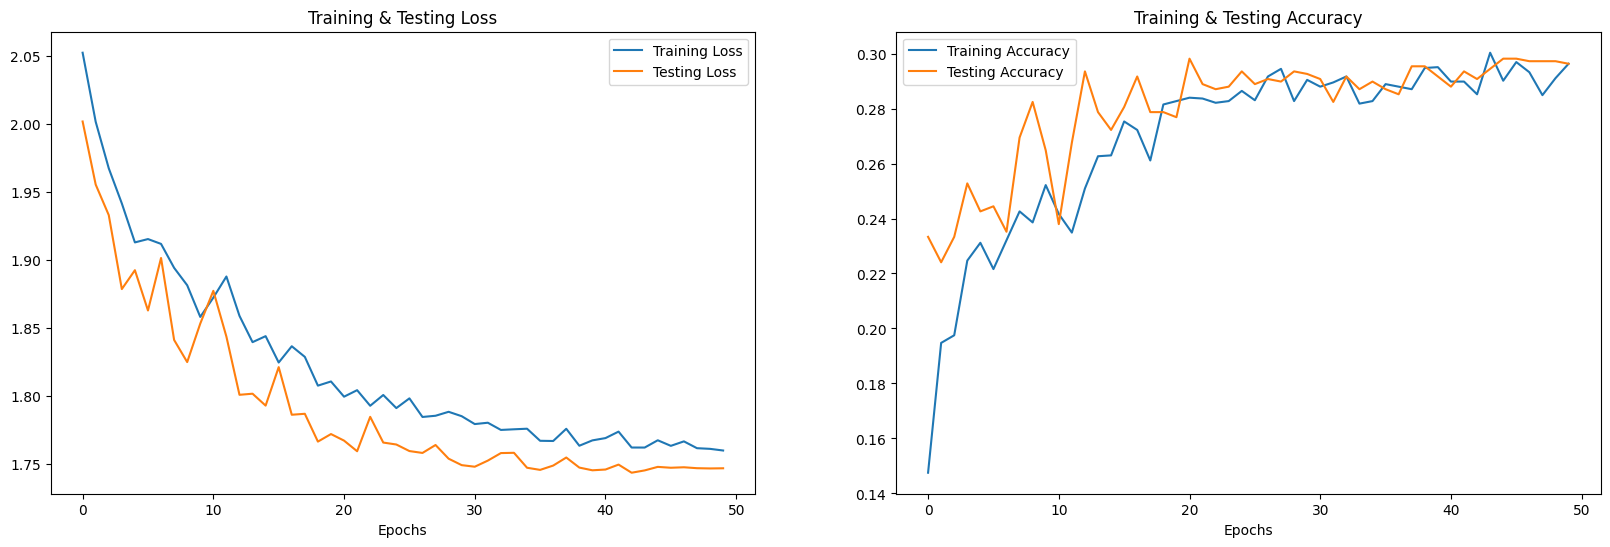

In [47]:
# test model

print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [48]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 2s 45ms/step


In [49]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,happy,happy
1,surprise,disgust
2,sad,sad
3,sad,sad
4,happy,sad
5,disgust,neutral
6,calm,calm
7,disgust,angry
8,sad,sad
9,happy,happy


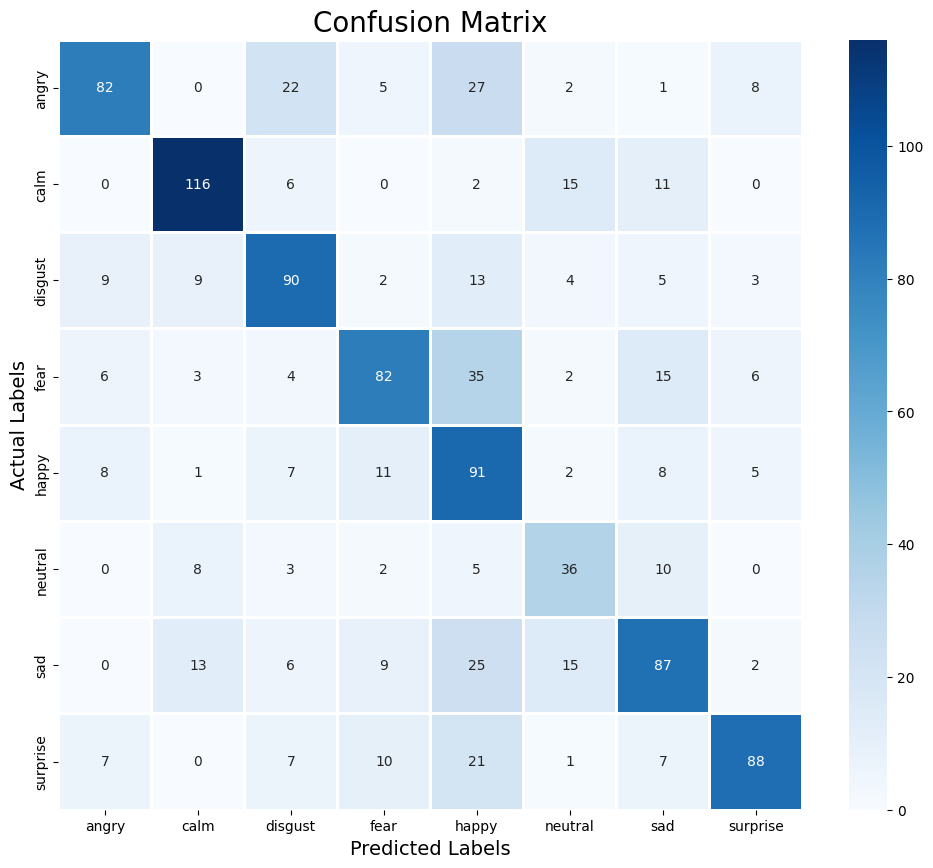

In [50]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.73      0.56      0.63       147
        calm       0.77      0.77      0.77       150
     disgust       0.62      0.67      0.64       135
        fear       0.68      0.54      0.60       153
       happy       0.42      0.68      0.52       133
     neutral       0.47      0.56      0.51        64
         sad       0.60      0.55      0.58       157
    surprise       0.79      0.62      0.70       141

    accuracy                           0.62      1080
   macro avg       0.63      0.62      0.62      1080
weighted avg       0.65      0.62      0.63      1080

